# Fixed Income Derivatives - The Libor Market Model Example
In this problem, we will construct a Libor market model and use this model to compute the price of a complicated derivative. In the table below, you will find ZCB spot rates $R(0,T_1)$ deduced from market data as well as spot caplet implied volatilies corresponding to caplets on one year Libor with a strike of $K = 0.045$

$$
\begin{array}{cccccc}
T_i & 1 & 2 & 3 & 4 & 5 \\
\hline
R(0, T_i) & 0.03731561 & 0.04106146 & 0.04370112 & 0.04556125 & 0.04687207 \\
\bar{\sigma}_i & - & 0.041 & 0.052 & 0.065 & 0.083 \\
\hline
\end{array}
$$

The spot implied volatility $\bar{\sigma}_i = \bar{\sigma}(0; T_{i−1},T_i)$ is the implied volatility of a call option on $1Y$ Libor announced at time $T_{i−1}$ and paid at time $T_i$.


In [1]:
import sys
import os
# add the directory
sys.path.append(os.path.abspath("../../Files"))
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

import numpy as np
from scipy.linalg import sqrtm

# import own module
import fixed_income_derivatives_E2024 as fid
import plotting as plot

%load_ext autoreload
%autoreload 2

## Problem 1 - Pricing an interest rate cap from market prices

#### (a) Plot one year forward Libor rates and plot these along with the spot rates given above.

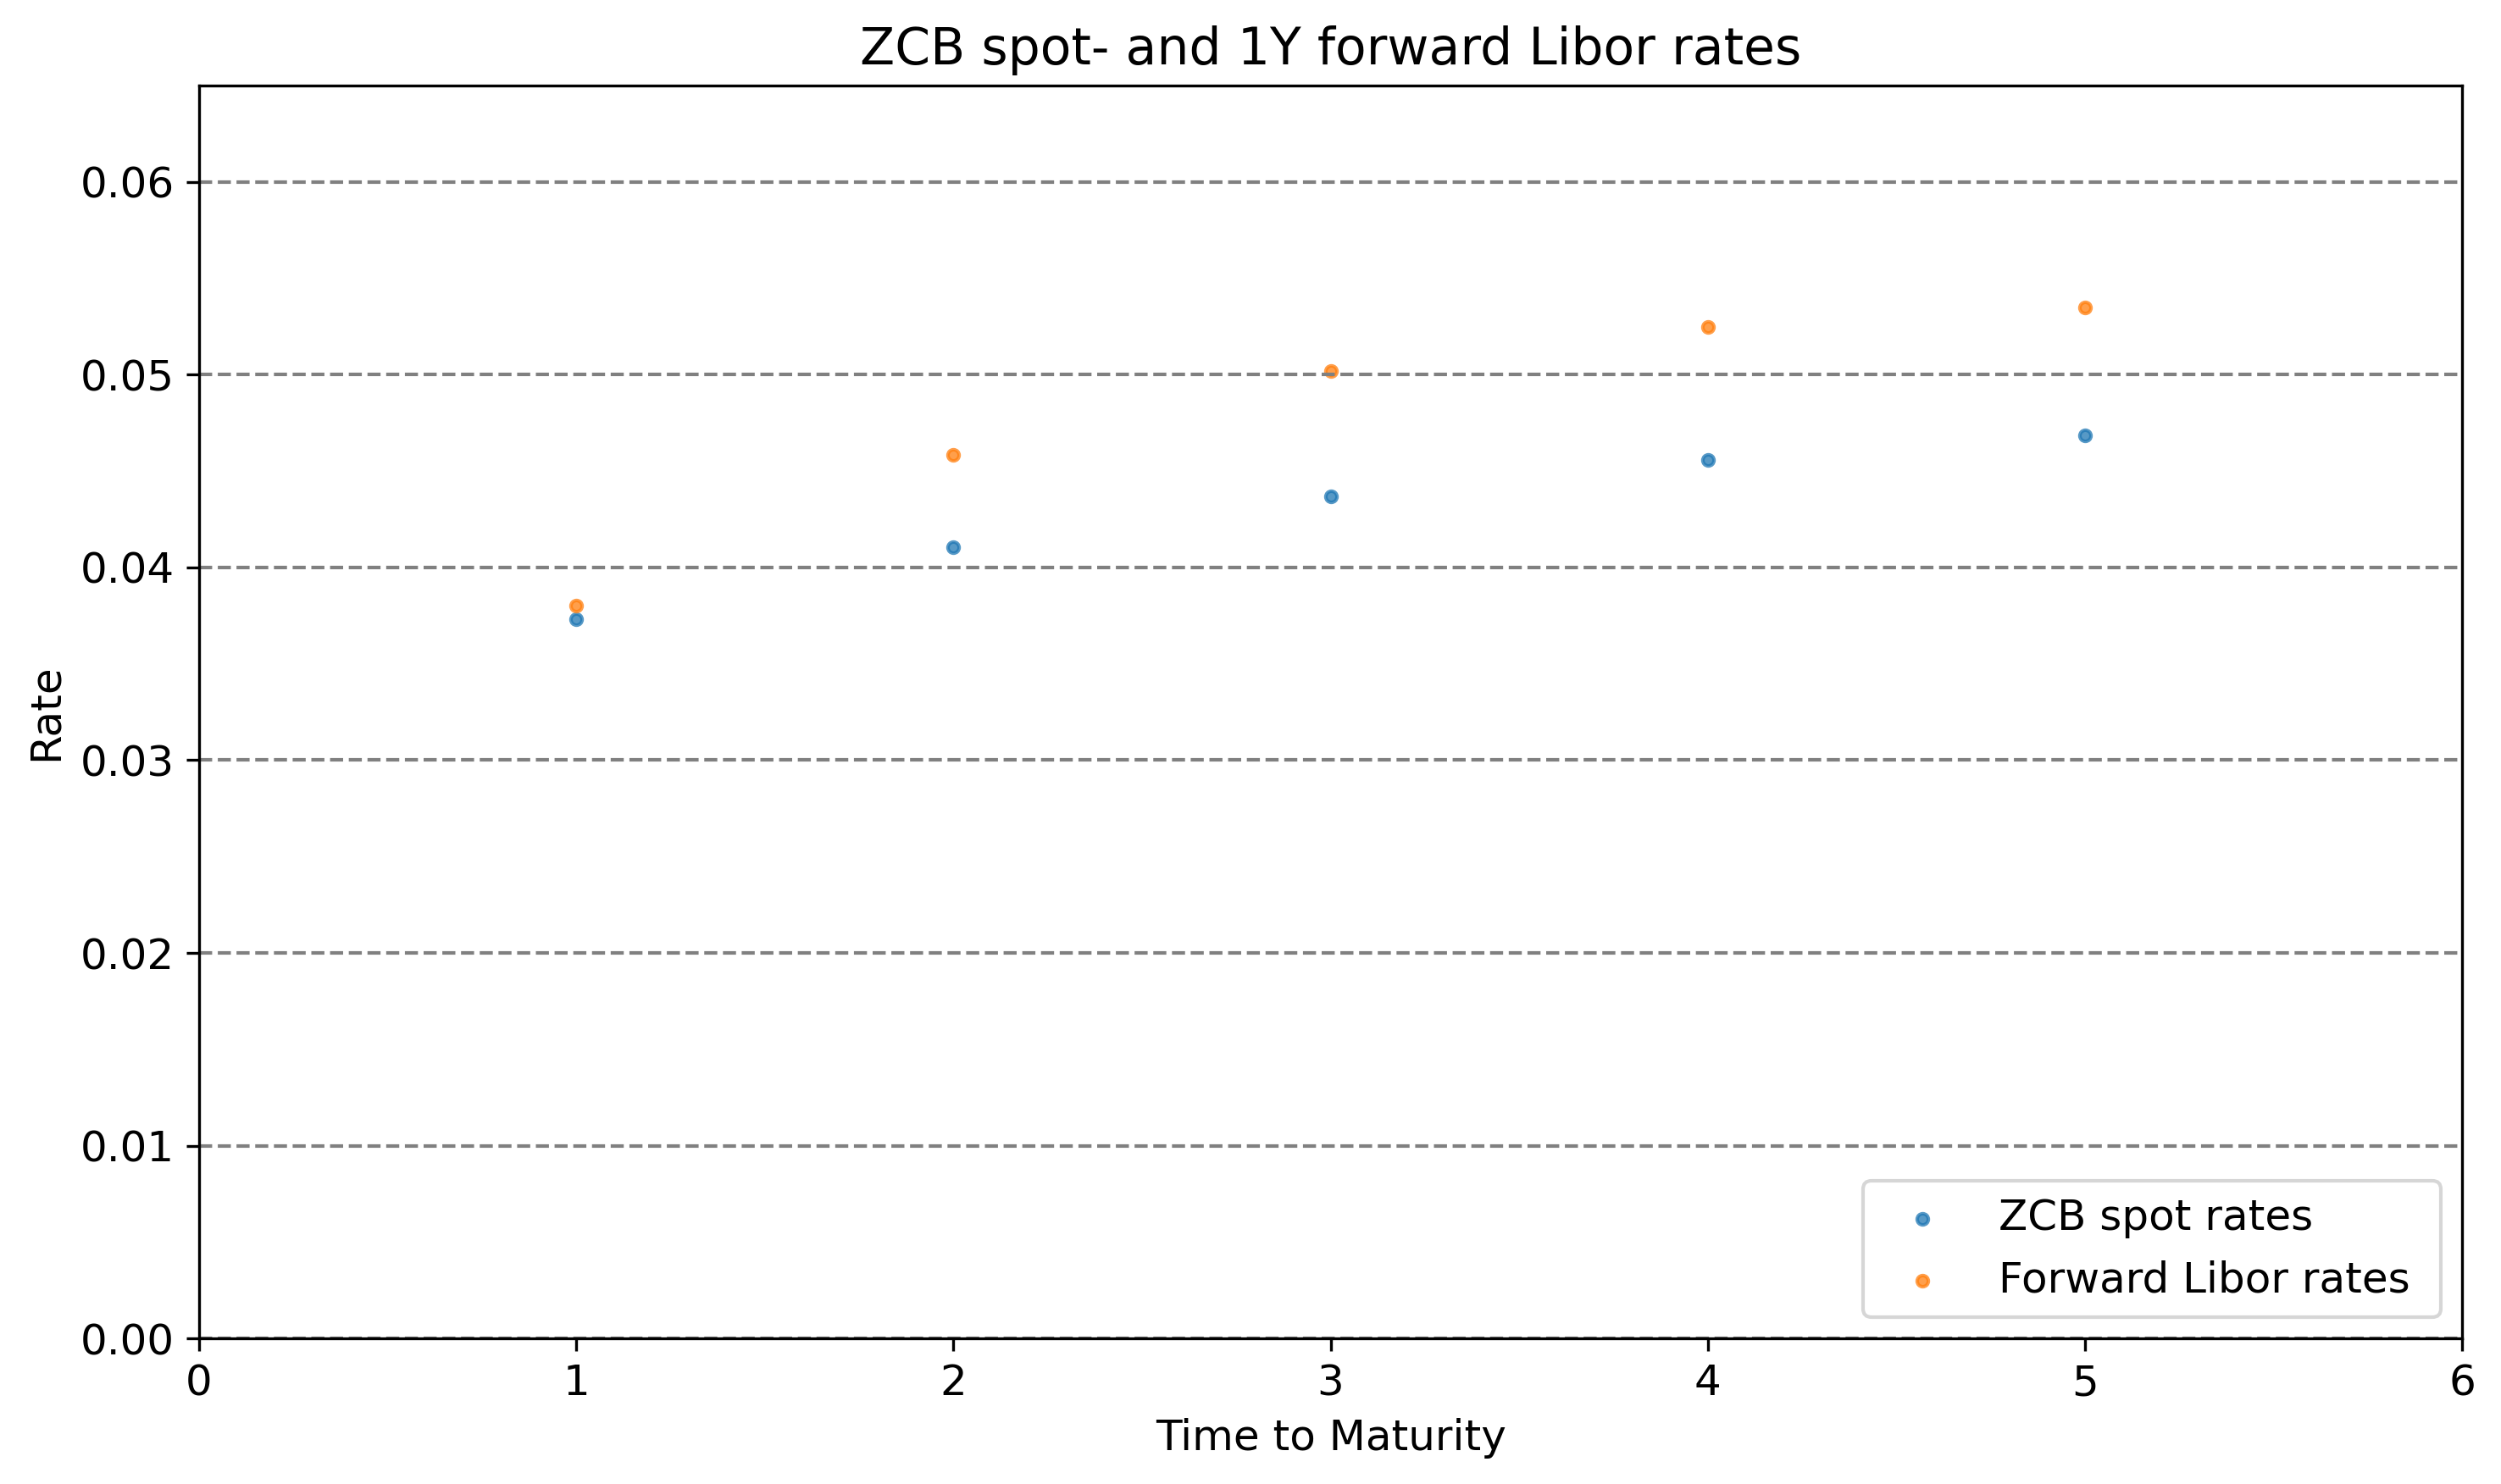

In [2]:
M = 6 # number of time intervals
R = np.array([np.nan,0.03731561,0.04106146,0.04370112,0.04556125,0.04687207])
alpha = 1
T = np.array([m*alpha for m in range(0,M)])
p = np.ones(M) # price of zero coupon bond at the given time
L, alpha = np.zeros(M), np.zeros(M)
sigma_lmm = np.ones(M)
for i in range(1,M):
    p[i] = np.exp(-R[i]*T[i])
    alpha[i] = T[i]-T[i-1] # alpha does not have to be 1 as in this case, time intervals could be different
    L[i] = (1/alpha[i])*(p[i-1] - p[i])/p[i]

# plot
rates_plot = [{'label':'ZCB spot rates', 'x':T[1:], 'y':R[1:],'s':40},
              {'label':'Forward Libor rates', 'x':T[1:], 'y':L[1:],'s':40}]

plot.rates(rates_plot, title = 'ZCB spot- and 1Y forward Libor rates',xrange=[0,6])

#### (b)Compute the price of an interest cap on one year Libor that starts today, has a strike of $K = 0.045$ and runs for 5 years. Report the price in terms of an amount in bps paid upfront and also as an annualized premium paid periodically in the future at times $T = 1,2,3,4,5$.

We will use the following model to price the caplet:
$$
\begin{align*}
\Pi &= \text{premium (annual)} \\
NPV(cap) &= \sum_{i=1}^5 p(0,T_i)\alpha_i \Pi \Leftrightarrow \\
\Pi &= \frac{NPV(cap)}{\sum_{i=1}^5 p(0,T_i)\alpha_i}, \quad \text{where } \sum_{i=1}^5 p(0,T_i)\alpha_i \ \text{ is the accural factor of a 5 year interest rate swap} \\
\end{align*}
$$

In [3]:
strike = 0.045
sigma_market_045 = np.array([0,0,0.041,0.052,0.065,0.083])
price_caplet_1b = np.zeros(M)

for i in range(2,M):
    price_caplet_1b[i] = fid.black_caplet_price(sigma_market_045[i],T[i],strike,alpha[i],p[i],L[i],type = 'call')
print(f"caplet prices: {price_caplet_1b*10000} bps.")
price_cap_1b = sum(price_caplet_1b)
print(f"cap price: {price_cap_1b*10000} bps.") # in basis points of the notional
R_swap_1b, S_swap_1b = fid.swap_rate_from_zcb_prices(0,0,5,"annual",T,p)
print(f"R_swap_1b: {R_swap_1b}, S_swap_1b: {S_swap_1b}")
premium_1b = price_cap_1b/S_swap_1b
print(f"cap annual premium_1b: {premium_1b*10000} bps")

caplet prices: [ 0.          0.         13.9535606  47.6539042  65.33309558 74.02215228] bps.
cap price: 200.96271265421674 bps.
R_swap_1b: 0.04763270099674098, S_swap_1b: 4.3861317034117775
cap annual premium_1b: 45.8177561102182 bps


#### (c) Compute the price of the cap if it is to only cover future Libor rates announced from $T_{i−1} = 2$ and beyond. Report you answer both as an upfront payment and as an amount paid periodically from time $T = 3$.

In [4]:
price_cap_1c = sum(price_caplet_1b[3:]) # on cover caplets from time T=3
print(f"cap price: {price_cap_1c*10000}.")
R_swap_1c, S_swap_1c = fid.swap_rate_from_zcb_prices(0,2,5,"annual",T,p)
print(f"R_swap_1c: {R_swap_1c}, S_swap_1c: {S_swap_1c}")
premium_1c = price_cap_1c/S_swap_1c
print(f"cap annual premium: {premium_1c*10000}")

cap price: 187.00915205778614.
R_swap_1c: 0.05199950984678004, S_swap_1c: 2.501600942990318
cap annual premium: 74.7557889206112


A client has contacted you because he wants a quote on an interest rate cap of the same type as the one in problem 1b) but with a strike of $0.0475$. However, there are no caplets available for that strike but there are caplets available for a strike of $K = 0.05$ and they trade at the following implied volatilities

$$
\begin{array}{cccccc}
T_i & 1 & 2 & 3 & 4 & 5 \\
\hline
\bar{\sigma}_i & - & 0.045 & 0.057 & 0.073 & 0.096 \\
\hline
\end{array}
$$

### (d) Compute the price of an interest cap on one year Libor that starts today, has a strike of $K = 0.05$ and runs for 5 years. Report the price in terms of an amount in bps paid upfront and also as an annualized premium paid periodically in the future at times $T = 1,2,3,4,5$


In [5]:
sigma_market_050 = np.array([0,0,0.045,0.057,0.073,0.096])
strike = 0.05
# Problem 1d
price_caplet_1d = np.zeros(M)
for i in range(2,M):
    price_caplet_1d[i] = fid.black_caplet_price(sigma_market_050[i],T[i],strike,alpha[i],p[i],L[i],type = 'call')

print(f"caplet prices: {price_caplet_1d*10000} bps.")
price_cap_1d = sum(price_caplet_1d)
print(f"cap price: {price_cap_1d*10000} bps.")
R_swap_1d, S_swap_1d = fid.swap_rate_from_zcb_prices(0,0,5,"annual",T,p)
print(f"R_swap_1d: {R_swap_1d}, S_swap_1d: {S_swap_1d}")
premium_1d = price_cap_1d/S_swap_1d
print(f"cap annual premium_1d: {premium_1d*10000} bps.")

caplet prices: [ 0.          0.          1.09928057 18.1912882  36.49168066 50.53728911] bps.
cap price: 106.31953854258 bps.
R_swap_1d: 0.04763270099674098, S_swap_1d: 4.3861317034117775
cap annual premium_1d: 24.239932982376875 bps.


## Problem 2 - The Libor Market Model
To quote a price on an interest rate cap with a strike of $0.0475$, you could of course take some sort of average between the price in 1b) and the price in 1c) but that is rarely how the problem is solved in practice when more complicated derivatives on Libor or other reference rates for which caplets exist. Instead, market participants typically construct a so called Libor market model. In the following we will consider a set of Libor fixings occuring at $T_0,T_1,...,T_{N−1}$ corresponding to Libor rate payments at $T_1,...,T_N$ and denote the Libor rate $L(t; T_{i−1},T_i) by $L_i(t)$. Also, we will denote the ZCB paying one dollar at time $T_i$ by $p(t,Ti)$.

***See ChatGPT for proposed solution***

***Notes from class are commented out***
<!-- $$
\begin{align*}
\bar{\sigma}_i^2 = \frac{1}{T_i}\int_0^{T_{i-1}} = \sigma_i^2(t)dt \\
\sigma_i = \text{constant} \\
\bar{\sigma}_i^2 = \frac{T_{i-1}}{T_i} \sigma_i^2  \\
\sigma_i^2 = \frac{T_i}{T_{i-1}} \bar{\sigma}_i^2
\end{align*}
$$ -->

#### (a) Write the dynamics of the Libor rates $L_i(t)$ when driven by a $K$-dimensional Brownian motion $W^i_t$ under the $T_i$ forward measure $\mathbb{Q}_i$. Discuss why $L_i(t)$ must be a martingale under $\mathbb{Q}_i$ and also discuss what happens to $L_i(t)$ after time $T_{i−1}$.

#### (b) Impose conditions on the diffusion coeficients so as to ensure that the Libor model is consistent with observed caplet prices

#### (c) Now give the dynamics of $L_i(t)$ under the unifying measure $\mathbb{Q}^N$ and specify the drift of each of the Libor rates under this new measure

#### (d) Argue that the Libor market model can also be constructed such that the diffusion coefficients are scalar valued but the Brownian motions driving the Libor rates are correlated

## Problem 3 - Constructing a Libor market model and using it to price a cap
In the Libor Market Model we wish to construct, we have that $T_N= T_5 = 5$ and we will model the Libor rates $L_1(t)$, $L_2(t)$, $L_3(t)$ and $L_4(t)$. In this version of the Libor market model, we will simply assume that the diffusion coefficients are constant so the diffusion coefficient of $L_i(t)$ is the constant $\sigma_i$. Also, assume that you wish the correlation matrix of the Libor rates in your model to be given by the matrix $\Omega$, where
$$
\Omega =
\begin{bmatrix}
1 & 0.95 & 0.9 & 0.85 \\
0.95 & 1 & 0.95 & 0.9 \\
0.9 & 0.95 & 1 & 0.95 \\
0.85 & 0.9 & 0.95 & 1
\end{bmatrix}
$$

***Notes from class are commented out***
<!-- Time of fixing at $T_0$, $T_1$, $T_2$, $T_3$, $T_4$.

Libor cahsflows at $T_1$, $T_2$, $T_3$, $T_4$, $T_5$.

Model: $L_2(t)$, $L_3(t)$, $L_4(t)$, and $L_5(t)$

$L_2(t)$ is "wiggeling" until $T_1$ where it is fixed to be paid at $T_2$. The same goes for $L_3(t)$, $L_4(t)$, and $L_5(t)$, being fixed at $T_2$, $T_3$, and $T_4$ respectively as seen in the figure below.

We have a system of libor rates
$$
\bar{L}(t) = \begin{bmatrix} L_2(t) \\ L_3(t) \\ L_4(t) \\ L_5(t) \end{bmatrix} \\
d\bar{L}(t) = \begin{bmatrix} \sigma_2 & 0 & 0 & 0 \\ 0 & \sigma_3 & 0 & 0 \\ 0 & 0 & \sigma_4 & 0 \\ 0 & 0 & 0 & \sigma_5 \end{bmatrix} \underset{4 \times 4}{A}\begin{bmatrix} dW_1(t) \\ dW_2(t) \\ dW_3(t) \\ dW_4(t) \end{bmatrix}
$$
$$
A_{i\cdot} A_{\cdot i} = 1 \quad \text{where } \cdot \in \text{ are elements in the matrix}
$$
$$
AA' = \Omega = \begin{bmatrix} 1 & \cdots \\ \rho_{21} &  \cdots \\ \rho_{31} & \cdots \end{bmatrix}
$$
Then difufusion coefficient (scalar) will be $\sigma_i$(t) and $Corr[L_i(t), L_k(t)] = \rho_{ik}$

If $W(t)$ is a K-dimensional vector of independent Brownian motion, then the what is Covariance matrix og $\underset{K \times K}{A}\underset{K \times 1}{W(t)}$?

The covariance materix would be 
$$
A \cdot \begin{bmatrix} t & 0 & 0 & 0 \\ 0 & t & 0 & 0 \\ 0 & 0 & t & 0 \\ 0 & 0 & 0 & t \end{bmatrix} \cdot A'
$$
The cpalet $Capl_i(t)$ is in th LMM a $\mathbb{Q}^N$ martingale and is given by
$$
\frac{Capl_i(t)}{p(t,T_i)} = \overset{\mathbb{Q}^N}{\mathbb{E}}\left[\frac{Capl_i(T_N)}{p(T_N,T_i)}\right], \quad \text{where } N = 5 \text{ (for our case)} \\
= \overset{\mathbb{Q}^N}{\mathbb{E}}[Capl_i(T_N)]
$$
Remeber if $i=3$ and $N=5$ then we can discount the cashflow forwards to $T_5$ using the subsequent LIBOR rates
$$ 
1+\alpha L(t,T) = \frac{1}{p(t,T)} \\
p(0,T) = p(0,s)p(0,s,T)
$$

Here we are using the higher sigmas (form 5%) to simulate which is a more conservative approach and will give higher prices for the caplet compared to the lower sigmas (from 4%).  -->

#### (a) Use the implied volatilities from problem 1b) to find a vector of diffusion coefficients that we must use in our Libor market model for our model to be consistent with the market observed implied volatilities in 1b)

As $L_1(t)$ corresponds to the rate at $T_1$ to $T_2$ and $L_2(t)$ corresponds to the rate at $T_2$ to $T_3$, we must use the $\bar{\sigma}_i$ in the vector of diffusion coefficients but scale it with $\sqrt{\frac{T_i}{T_{i-1}}}$ as $\bar{\sigma}_i = \bar{\sigma}(0; T_{i−1},T_i)$ is the accumulated variance from $t=0$ until $T_i$.
$$
\sigma_{i-1} = \bar{\sigma}_i \sqrt{\frac{T_i}{T_{i-1}}}
$$
***If variance had been annualized (LIBOR model and market standard) then this would be the scaling:***
$$
\sigma_{i-1} =  \bar{\sigma}_i\frac{1}{\sqrt{T_i-T_{i-1}}}
$$

#### (b) Discuss how to create Brownian motion with correlation matrix $\Omega$

#### (c) Write a function in Python that computes the drift of the Libor rates in the Libor market model and use this function to write another function that will allow you to simulate Libor rates in the Libor market model. Plot a simulated trajectory for the Libor rates in your model

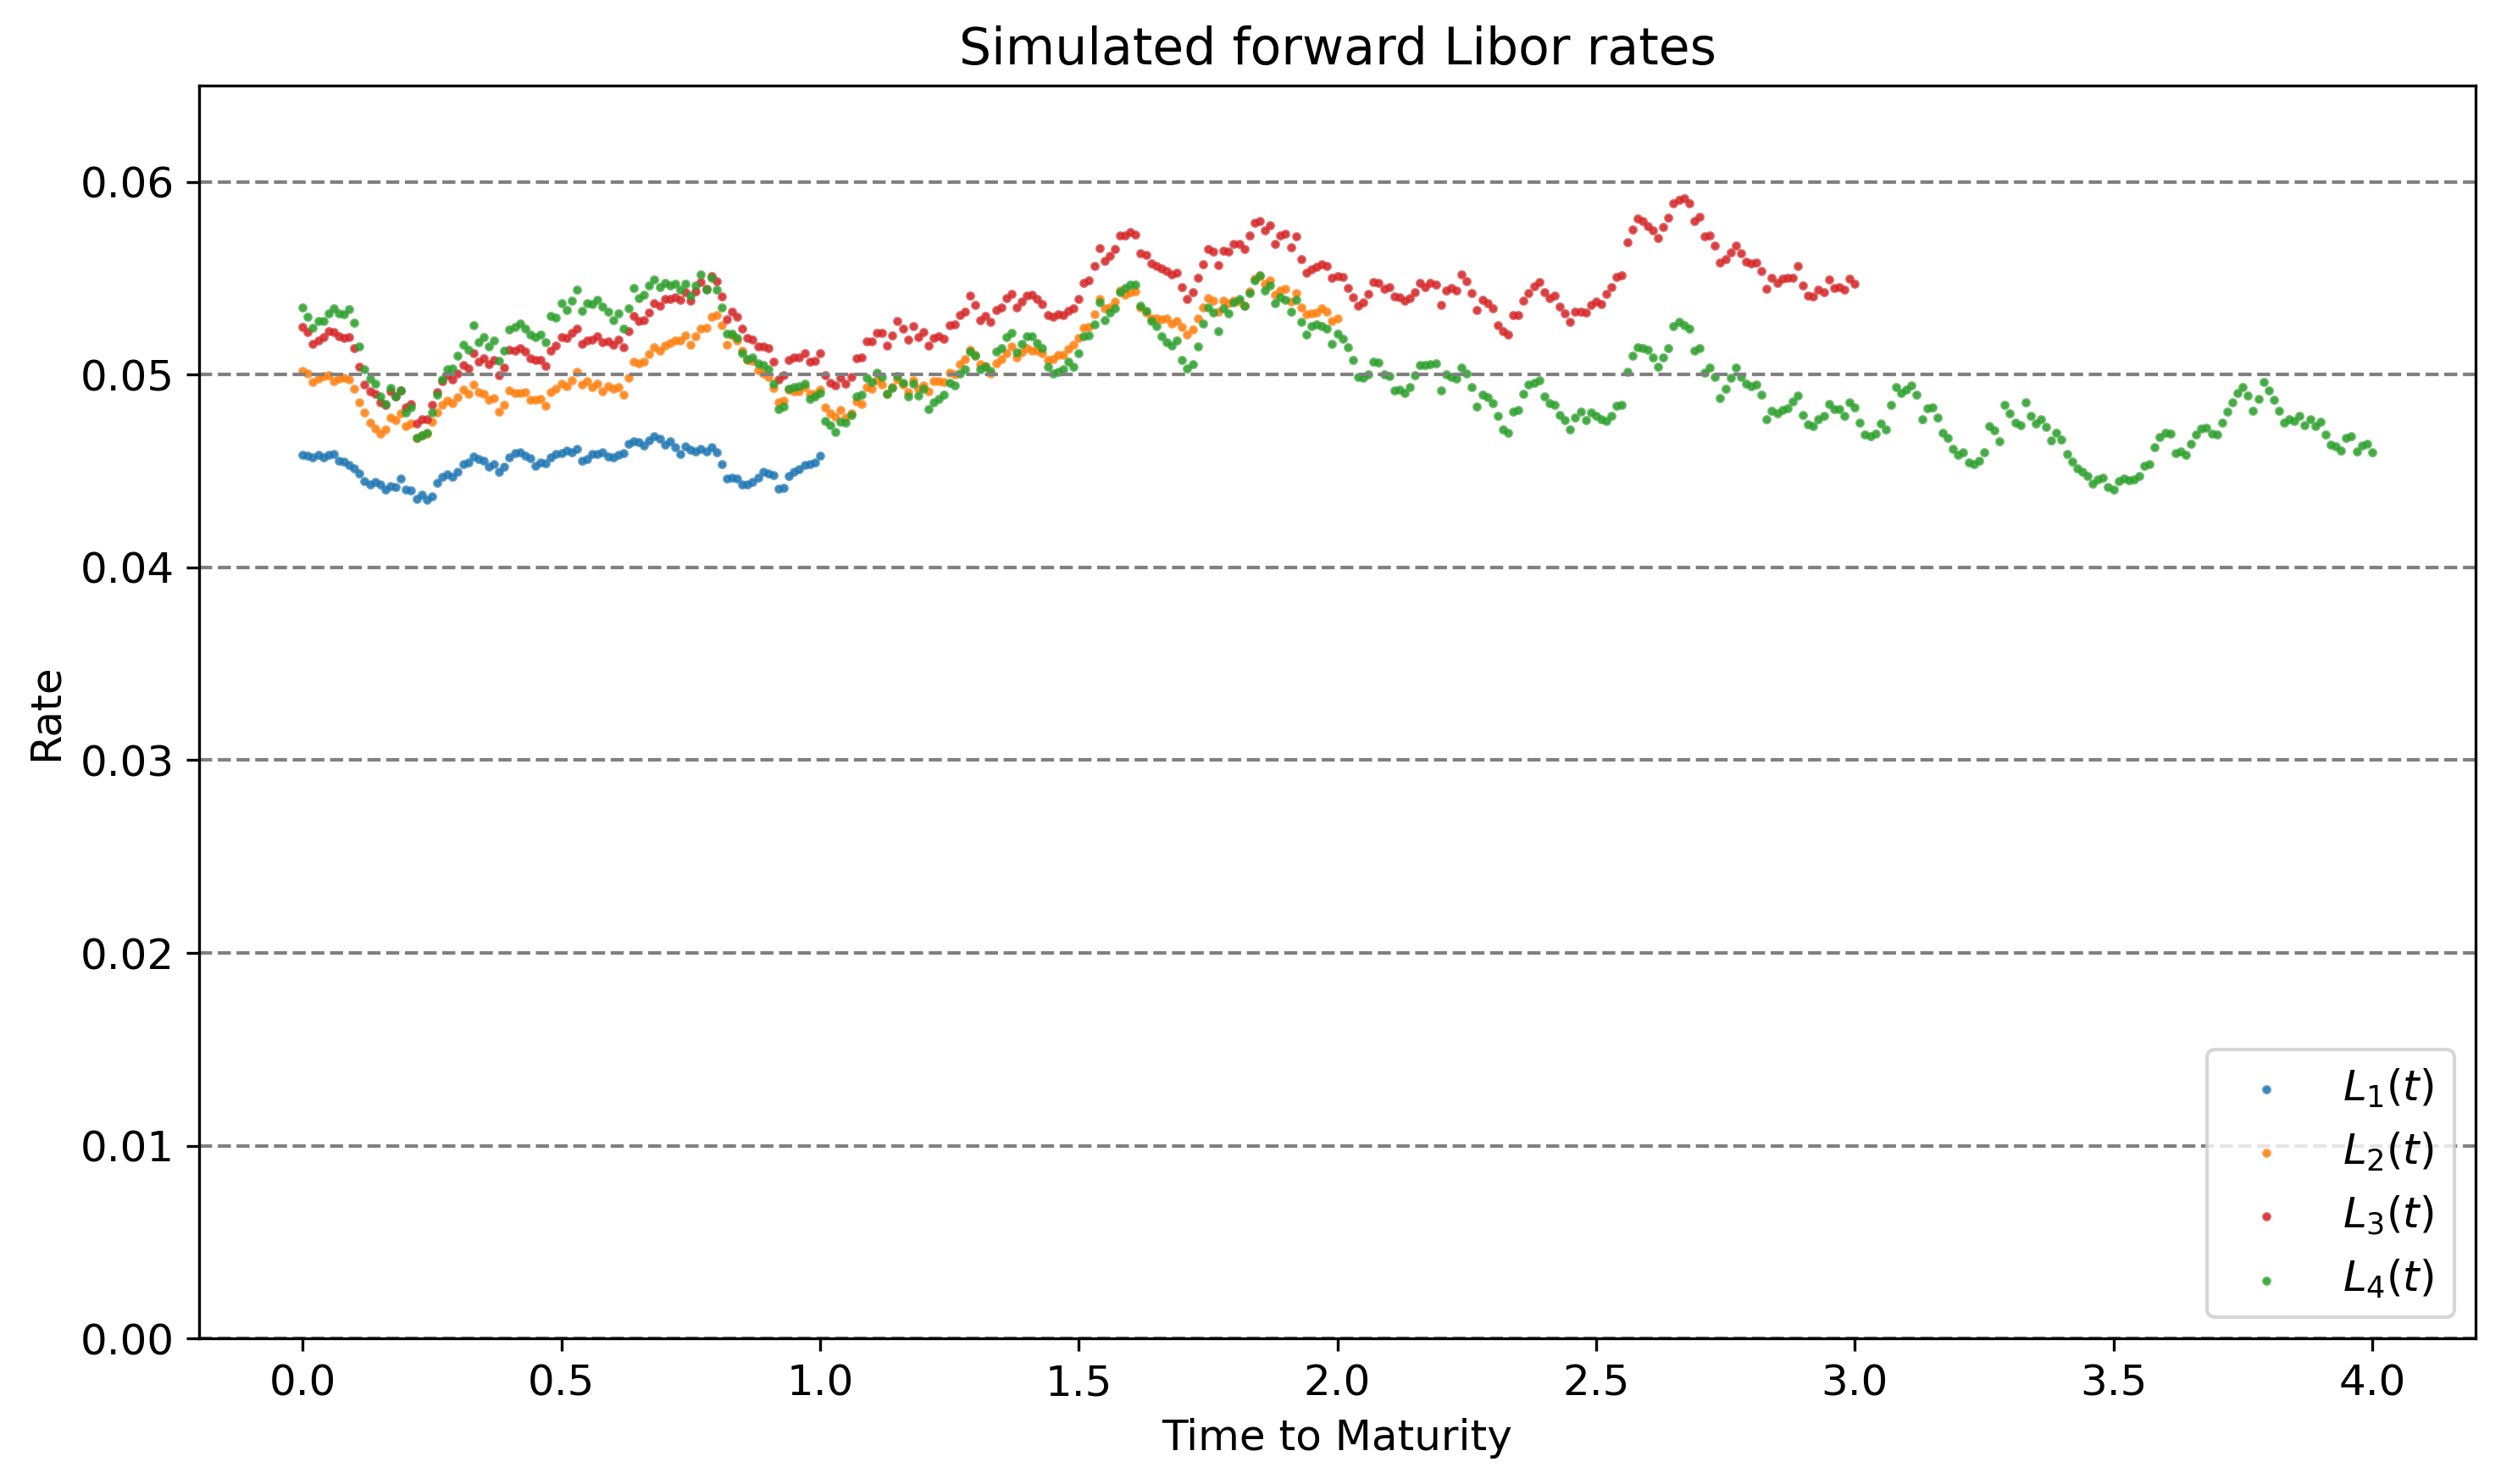

In [6]:
np.random.seed(2024) # seed not used by JLS but used by me for reproducibility
M_simul, T_simul = 400, 4
t_simul = np.array([i*T_simul/M_simul for i in range(0,M_simul+1)])
Omega = np.array([[1,0.5,0.9,0.85],[0.95,1,0.95,0.9],[0.9,0.95,1,0.95],[0.85,0.9,0.95,1]])
rho_sqrt = sqrtm(Omega)

sigma_lmm = np.zeros([M-2])
for i in range(0,M-2):
    sigma_lmm[i] = sigma_market_045[i+2]*np.sqrt(T[i+2]/T[i+1])

# simulate once
L_simul = fid.simul_lmm(L[2:M],T[1:M],sigma_lmm,Omega,M_simul)

np.random.seed(2025)
strike_lmm = 0.0475
N_simul = 1000
L_exercise = np.zeros(M-2)
chi_disc = np.zeros([M-2,N_simul])
for n in range(0,N_simul):
    # path
    L_simul = fid.simul_lmm(L[2:M],T[1:M],sigma_lmm,Omega,M_simul)

    # exercise values
    for j in range(0,M-2):
        L_exercise[j] = L_simul[j,int(j*M_simul/4)+1]
        chi_disc[j,n] = p[-1]*alpha[j+2]*max(L_exercise[j] - strike_lmm,0)
        for k in range(j,M-2):
            chi_disc[j,n] *= (1+alpha[k+2]*L_exercise[k])

simul_plot = [{'label':'$L_1(t)$', 'x':t_simul, 'y':L_simul[0,:],'s':10},
              {'label':'$L_2(t)$', 'x':t_simul, 'y':L_simul[1,:],'s':10},
              {'label':'$L_3(t)$', 'x':t_simul, 'y':L_simul[2,:],'s':10},
              {'label':'$L_4(t)$', 'x':t_simul, 'y':L_simul[3,:],'s':10}]

plot.rates(simul_plot, title = 'Simulated forward Libor rates',)

#### (d) Compute the price of the interest rate cap with a strike of $K = 0.0475$. Be sure to ’discount’ the cashflow at exercise correctly remembering that we are simulating under $\mathbb{Q}^5$. Discuss if it is reasonable to use the market implied volatilities from 1b). Could other choices of implied volatilities have been justified and finally discuss the use of the Libor Market model when caplet prices are available for several strikes

In [7]:
# Problem 3 - Simulation of the Libor market model
caplet_price_3 = np.zeros(M-2)
for i in range(0,M-2):
    caplet_price_3[i] = sum(chi_disc[i,:])/N_simul*10000
print(f"caplet_price for a strike of {strike_lmm} is {caplet_price_3} bps, cap price: {sum(caplet_price_3)} bps")

caplet_price for a strike of 0.0475 is [ 0.         26.45286504 50.7737802  63.16979137] bps, cap price: 140.3964366074242 bps
